# Importation et préparation des données

In [1]:
#=========== Importation des librairies ===============

import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm, model_selection
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
import keras as ks
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers import AvgPool2D, BatchNormalization, Reshape
from keras.optimizers import Adadelta, RMSprop, Adam
from keras.losses import categorical_crossentropy
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [2]:
#=========== Importation des données et transformations en array ===============
data=pd.read_csv(r"C:\Users\Thiti\Desktop\M2 EKAP\S1\Python machine learning\house-prices-advanced-regression-techniques\train2.csv",sep=";")

# On definis Y et on le passe en np array pour effectuer les modèles

Y=np.asarray(data.Price_Class)  #copie les elements 

# Récupération du typage des variables
data_type = pd.DataFrame(data.dtypes.astype(str), columns=['type'])

# on enlève les variables explicatives
X = data.drop(columns = ['Price_Class','SalePrice'])

# Transformation des variables catégorielles en dummies
lvar_obj = list(data_type[data_type.type=='object'].index)
X = pd.get_dummies(data = X, columns = lvar_obj, drop_first = True)
X_col = list(X.columns)

X=np.asarray(X)
# Partitionnement en train et test des données
X_train, X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

# Passage des data set en np array
X_train=np.asarray(X_train)
Y_train=np.asarray(Y_train)
Y_test=np.asarray(Y_test)
X_test=np.asarray(X_test)

# Statistiques descriptives

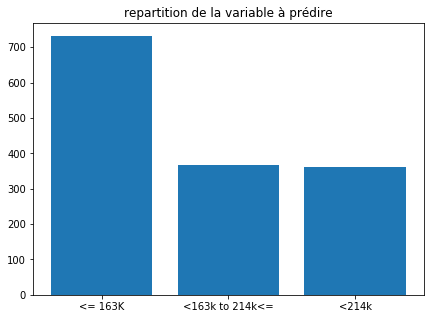

In [6]:
data.SalePrice.describe()
# mediane = 163 k
# Q2-Q3: 163 k -214 k
# Q3 = 214k
#Plot bar du Y

# Les classes de prix sont au nombre de 3: 
# 0 pour un prix allant du min à 163 000 inclus
# 1 de plus de 163 000 a 214 000 inclus
# 2 un prix de plus de 214 000

# Plot de la variable à prédire: Price Class

fig = plt.figure(figsize = (7, 5)) 
plt.bar(data.Price_Class.value_counts().index,data.Price_Class.value_counts().values,
        tick_label=['<= 163K',' <163k to 214k<= ','<214k'])
plt.title("repartition de la variable à prédire")
plt.show()

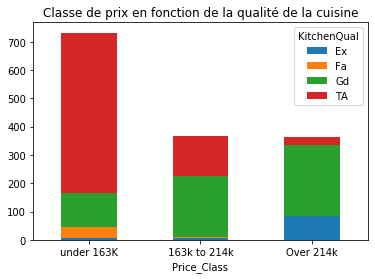

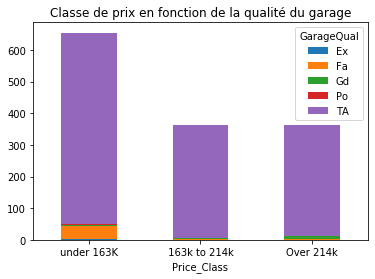

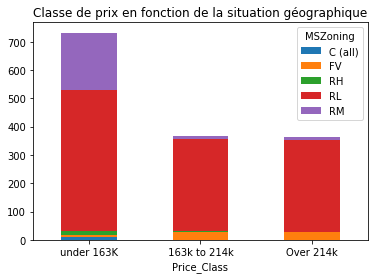

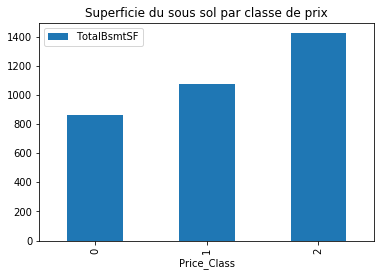

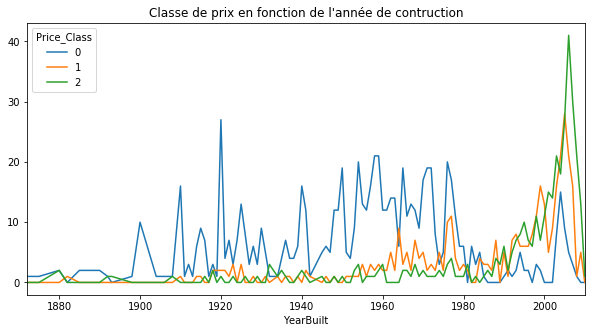

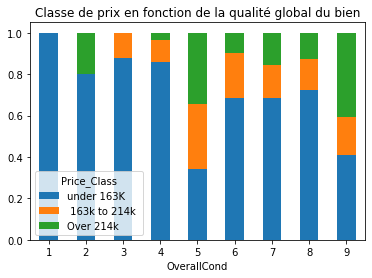

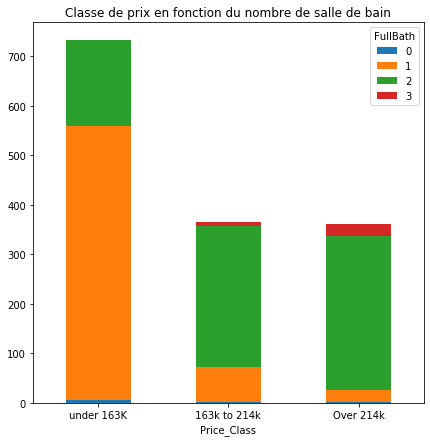

'relation croissance entre nbr de salle de bains et classe de prix'

In [34]:
######## Graphique croisés etre Y et nos X #########

# Kitchen

cross_df=pd.crosstab(data.Price_Class, data.KitchenQual)
cross_df=cross_df.rename(index={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'})

cross_df.plot.bar(stacked=True, title  = "Classe de prix en fonction de la qualité de la cuisine",rot=0)
plt.show()

'Il existe une relation entre la qualité de la cuisine et la classe prix du bien: plus la qualité est bonne plus la'
'classe de prix est grande'

# Garage

cross_df=pd.crosstab(data.Price_Class, data.GarageQual)
cross_df=cross_df.rename(index={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'})

cross_df.plot.bar(stacked=True, title  = "Classe de prix en fonction de la qualité du garage",rot=0)
plt.show()

'La qualité du garage ne semble pas impacté la classe de prix , pas un fort pouvoir predictif'

# MSZoning

cross_df=pd.crosstab(data.Price_Class, data.MSZoning)
cross_df=cross_df.rename(index={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'})

cross_df.plot.bar(stacked=True, title  = "Classe de prix en fonction de la situation géographique",rot=0)
plt.show()

'La situation géographique du bien semble imapcté légèrement la classe de prix'

# Les metres carrés au sous sol

mean_BsmtSF = data[["Price_Class","TotalBsmtSF"]].groupby(["Price_Class"]).mean()
mean_BsmtSF.plot.bar(title = "Superficie du sous sol par classe de prix")
tick_label=['<= 163K',' <163k to 214k<= ','<214k']
plt.show()

'relation positive logique, impact peut être non linéaire de cette variable sur le prix, le kernel gaussien en SVM'
'pourra peut être permettre de gagner en qualité de prédiction par rapport au kernel lineaire' 

# L'année de construction
cross_df=pd.crosstab(data.YearBuilt,data.Price_Class)
cross_df=cross_df.rename(index={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'})

cross_df.plot(title  = "Classe de prix en fonction de l'année de contruction",figsize=(10,5))
plt.show()

'beaucoup de bien de classe 1 construit avant les années 80'

# En fonction de la condition global de la maison

cross_df=pd.crosstab(data.OverallCond,data.Price_Class,normalize = "index")
cross_df=cross_df.rename(columns={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'})

cross_df.plot.bar(stacked=True,title  = "Classe de prix en fonction de la qualité global du bien",rot=0)
plt.show()

'relation similaire pour chaque classe de prix, mais la classe 0 est plsu présente pour des qualité <5 en proportion'
# En fonction des salles de bains

cross_df=pd.crosstab(data.Price_Class,data.FullBath)
cross_df=cross_df.rename(index={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'})

cross_df.plot.bar(stacked=True,title  = "Classe de prix en fonction du nombre de salle de bain",figsize=(7,7),rot=0)
plt.show()

'relation croissance entre nbr de salle de bains et classe de prix'

#  Modèles

## Modèles SVM

### SVM Linéaire

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  

C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packag

C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-pa

C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-package

[[92 45  8]
 [41 11 31]
 [12  1 51]]
52.739999999999995


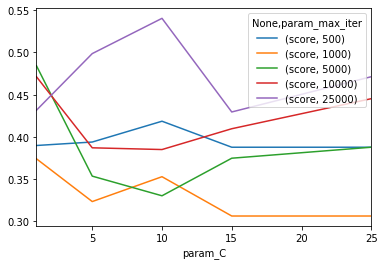

In [29]:
###### modèle SVM avec kernel linéaire ########

segments = KFold(n_splits = 5, shuffle = True, random_state = 0)

#On spécifie les hyper-paramètres, c'est à dire les paramètres qui seront testés lors de la cross validation:

hyper_params = [{'C':[1,5,10,15,25],'max_iter':[500,1000,5000,10000,25000]}]
#On vient donc spécifier les différents C et Gamma qui seront testés par Cross Validation

# On utilise toujours un modèle avec une fonction de noyau RBF.
model = SVC(kernel='linear',decision_function_shape='ovo')

# On spécifie une table de paramètre de la Cross validation(GridSearchCV()) 
#qui reprends les hyper-paramètres et les paramètres de la segmentation évoqués plus haut

model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = segments, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X,Y)
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results
BP=model_cv.best_params_
BP
# On plot les courbe de performance des différentes estimations

gridsearch_result = pd.DataFrame(cv_results[["param_C","param_max_iter"]])
gridsearch_result["score"] = cv_results["mean_test_score"]
gridsearch_result[["param_C","param_max_iter","score"]].groupby(['param_C','param_max_iter']).mean().unstack().plot()

# Fitting the best model

model_best = SVC(kernel="linear",max_iter=25000,C=10,decision_function_shape='ovo')
model_best.fit(X_train,Y_train)
Y_pred=model_best.predict(X_test)

# affichage des réultats
print(confusion_matrix(Y_test,Y_pred))
print(round(accuracy_score(Y_test,Y_pred),4)*100)

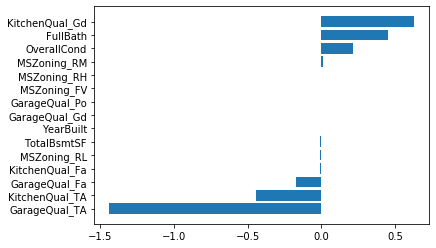

Text(0.5, 0, 'Price Class')

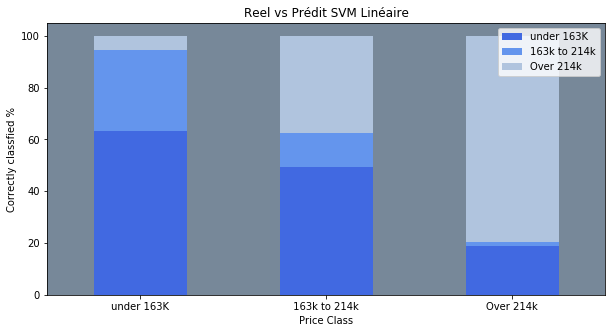

In [30]:
# affichage des coefficients les plus importants

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
f_importances(model_best.coef_.ravel(), X_col)

# Stacked bar plot avec matplotlib
cross_df=pd.crosstab(Y_test, Y_pred,normalize='index')
cross_df=cross_df.rename(index={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'},
                         columns={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'})
cross_df=cross_df*100

#on utilise la fonction crosstab pour faire la matrice de confusion, normalize pour avoir % des observations bien classifiées

ax=cross_df.plot.bar(stacked=True, title  = "Reel vs Prédit SVM Linéaire",color=('royalblue','cornflowerblue','lightsteelblue'),
                  figsize=(10,5),legend='reverse',rot=0)
ax.set_facecolor("lightslategray")
plt.legend(('under 163K','163k to 214k','Over 214k'),loc=0)
plt.ylabel("Correctly classfied %")
plt.xlabel("Price Class")

### SVM avec Kernel gaussien

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler

C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Thiti\Anaconda3\lib\site-packag

[[126  12   7]
 [ 25  52   6]
 [  6  18  40]]
74.65753424657534


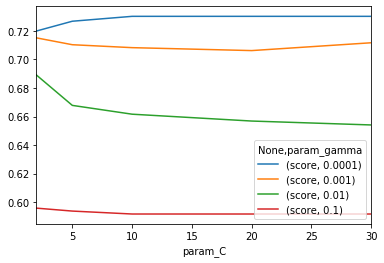

In [12]:
segments = KFold(n_splits = 5, shuffle = True, random_state = 0)

#On spécifie les hyper-paramètres, c'est à dire les paramètres qui seront testés lors de la cross validation:

hyper_params = [ {'gamma': [0.1, 0.01, 0.001,0.0001], 'C': [2,5,10,20,30]}]
#On vient donc spécifier les différents C et Gamma qui seront testés par Cross Validation

# On utilise toujours un modèle avec une fonction de noyau RBF.
model = SVC(kernel="rbf",max_iter=2000,decision_function_shape='ovo')

# On spécifie une table de paramètre de la Cross validation(GridSearchCV()) 
#qui reprends les hyper-paramètres et les paramètres de la segmentation évoqués plus haut

model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = segments, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X,Y)
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results
BP=model_cv.best_params_
BP
# On plot les courbe de performance des différentes estimations

gridsearch_result = pd.DataFrame(cv_results[["param_C","param_gamma"]])
gridsearch_result["score"] = cv_results["mean_test_score"]
gridsearch_result[["param_C","param_gamma","score"]].groupby(['param_C',"param_gamma"]).mean().unstack().plot()

# Fitting the best model

model_best = SVC(kernel="rbf",C=10,gamma=0.0001,max_iter=2000)
model_best.fit(X_train,Y_train)
Y_pred=model_best.predict(X_test)

# affichage des réultats
print(confusion_matrix(Y_test,Y_pred))
print(accuracy_score(Y_test,Y_pred)*100)

Text(0.5, 0, 'Price Class')

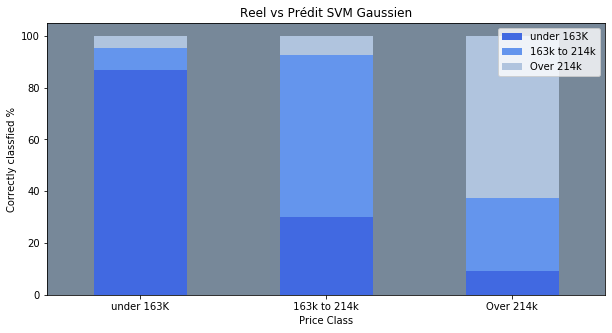

In [14]:
# Stacked bar plot avec matplotlib
cross_df=pd.crosstab(Y_test, Y_pred,normalize='index')
cross_df=cross_df.rename(index={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'},
                         columns={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'})
cross_df=cross_df*100

#on utilise la fonction crosstab pour faire la matrice de confusion, normalize pour avoir % des observations bien classifiées

ax=cross_df.plot.bar(stacked=True, title  = "Reel vs Prédit SVM Gaussien",color=('royalblue','cornflowerblue','lightsteelblue'),
                  figsize=(10,5),legend='reverse',rot=0)
ax.set_facecolor("lightslategray")
plt.legend(('under 163K','163k to 214k','Over 214k'),loc=0)
plt.ylabel("Correctly classfied %")
plt.xlabel("Price Class")

## Modèles ANN

In [3]:
#Fonction de perte des modèles ANN

def plot_history_loss_and_acc(history_keras_nn):

    fig, axs = plt.subplots(1,2, figsize=(12,4))

    axs[0].plot(history_keras_nn.history['loss'])
    axs[0].plot(history_keras_nn.history['val_loss'])
    axs[0].set_title('model loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'validation'], loc='upper left')

    axs[1].plot(history_keras_nn.history['accuracy'])
    axs[1].plot(history_keras_nn.history['val_accuracy'])
    axs[1].set_title('model accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'validation'], loc='upper left')

    plt.show()

In [4]:
# Passage des Y en categorical

Y_train=to_categorical(Y_train)
#On fait une copie de l'échantillion test pour faire la matrice de confusion, sinon le format ne permet pas d'afficher la matrice de confusion

Y_test2=Y_test
Y_test=to_categorical(Y_test)

### ANN avec 1 couche cachées

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


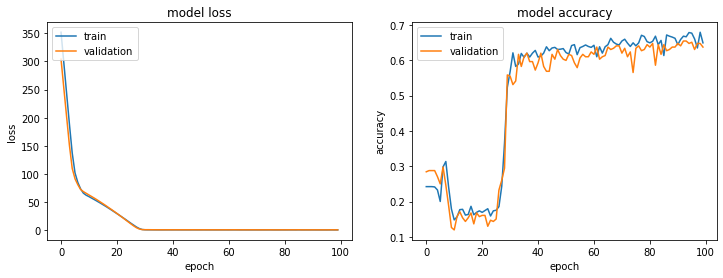

[[126  13   6]
 [ 44  11  28]
 [  7   8  49]]
63.6986301369863


In [5]:
batchsize = 100

def dense_model_0():
    model = Sequential()
    model.add(Dense(3, input_dim=15, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_dense_0 = dense_model_0()
model_dense_0.summary()

# Fit des modèles ANN

history_dense_0 = model_dense_0.fit(X_train, Y_train, validation_data=(X_test,Y_test),epochs=100, 
                                    batch_size=batchsize, verbose = 0)

# Affichage des résultats

plot_history_loss_and_acc(history_dense_0)

y_pred_dense0 = model_dense_0.predict_classes(X_test)

print(confusion_matrix(Y_test2, y_pred_dense0))
print(accuracy_score(Y_test2, y_pred_dense0)*100)

Text(0.5, 0, 'Price Class')

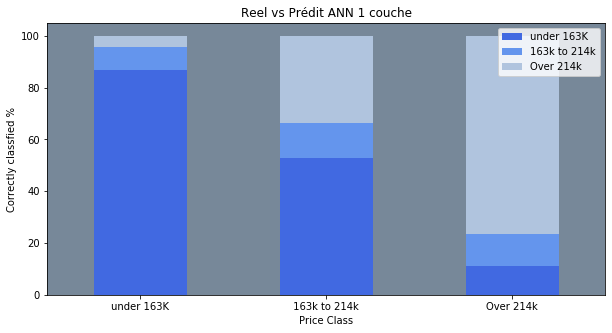

In [6]:
# Stacked bar plot avec matplotlib
cross_df=pd.crosstab(Y_test2, y_pred_dense0,normalize='index')
cross_df=cross_df.rename(index={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'},
                         columns={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'})
cross_df=cross_df*100

#on utilise la fonction crosstab pour faire la matrice de confusion, normalize pour avoir % des observations bien classifiées

ax=cross_df.plot.bar(stacked=True, title  = "Reel vs Prédit ANN 1 couche",color=('royalblue','cornflowerblue','lightsteelblue'),
                  figsize=(10,5),legend='reverse',rot=0)
ax.set_facecolor("lightslategray")
plt.legend(('under 163K','163k to 214k','Over 214k'),loc=0)
plt.ylabel("Correctly classfied %")
plt.xlabel("Price Class")

### ANN avec 2 couches cachées

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3)                 48        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 12        
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________


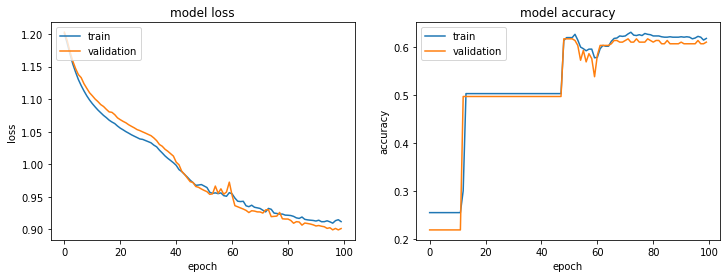

[[129   0  16]
 [ 47   0  36]
 [ 15   0  49]]
60.95890410958904


In [7]:
def dense_model_2():
    model = Sequential()
    model.add(Dense(3, activation='softmax', input_dim=15))
    model.add(Dense(3, activation='softmax',input_dim=15))    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_dense_2 = dense_model_2()
model_dense_2.summary()

history_dense_2 = model_dense_2.fit(X_train, Y_train, validation_data=(X_test,Y_test),epochs=100, 
                                    batch_size=batchsize, verbose = 0)

plot_history_loss_and_acc(history_dense_2)

y_pred_dense2 = model_dense_2.predict_classes(X_test)

print(confusion_matrix(Y_test2, y_pred_dense2))
print(accuracy_score(Y_test2, y_pred_dense2)*100)

Text(0.5, 0, 'Price Class')

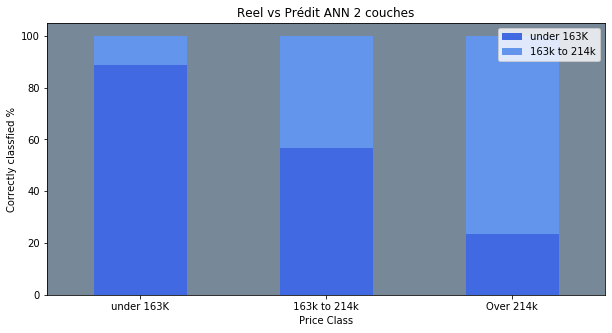

In [8]:
# Stacked bar plot avec matplotlib
cross_df=pd.crosstab(Y_test2, y_pred_dense2,normalize='index')
cross_df=cross_df.rename(index={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'},
                         columns={0:'under 163K',1:' 163k to 214k ',2:'Over 214k'})
cross_df=cross_df*100

#on utilise la fonction crosstab pour faire la matrice de confusion, normalize pour avoir % des observations bien classifiées

ax=cross_df.plot.bar(stacked=True, title  = "Reel vs Prédit ANN 2 couches",color=('royalblue','cornflowerblue','lightsteelblue'),
                  figsize=(10,5),legend='reverse',rot=0)
ax.set_facecolor("lightslategray")
plt.legend(('under 163K','163k to 214k','Over 214k'),loc=0)
plt.ylabel("Correctly classfied %")
plt.xlabel("Price Class")